In [1]:
# import required libraries
import numpy as np
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

# Enable logging
tf.logging.set_verbosity(tf.logging.INFO) 
tf.logging.log(tf.logging.INFO, "TensorFlow version " + tf.__version__)

#Read data
DATA = 'customers_timeseries_updated.csv' 
df = pd.read_csv(DATA,index_col=6)

#only using required columns for modelling
df = df[['client_debtor_number','fv_cost']]
# number of unique customers in the data
print("number of unique customers",len(df['client_debtor_number'].unique()))

INFO:tensorflow:TensorFlow version 1.11.0
number of unique customers 101


/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Scale_data function to scale data between (-1,1).input:dataframe to be scaled.
#output: scaled dataframe
def scale_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['fv_cost'] = min_max_scaler.fit_transform(df.fv_cost.values.reshape(-1, 1))
    return df

In [3]:
# train_dataset function to call training datasets for required batchsize
def train_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    print("dataset",dataset)
    # If not repeated data will stop after 1 epoch 
    dataset = dataset.repeat()
    dataset = dataset.padded_batch(BATCHSIZE, ((None,), (None,)))
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels

# eval dataset function to use test data for evaluation of the model
def eval_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    evaldataset = evaldataset.repeat(1)
    evaldataset = evaldataset.batch(BATCHSIZE)
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

#pred_dataset function to get prediciotns on train dataset
def pred_dataset():
    traindataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    traindataset = traindataset.repeat(1)
    traindataset = traindataset.batch(BATCHSIZE)
    samples, labels = traindataset.make_one_shot_iterator().get_next()
    return samples, labels

In [4]:
# model_rnn function is to create RNN LSTM model with required layers
def model_rnn(features, labels, mode):
    #create 2D tensor required for LSTM
    X = tf.expand_dims(features, axis=2)
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
    #create GRU cells to create RNN
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
    # Dropout layer to each rnn cell
    cells[:-1] = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=DROPOUT_PKEEP) for cell in cells[:-1]]
    # stacked RNN cell  
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float64) 
    # reshaping output to required format
    Yn = tf.reshape(Yn, [batchsize * seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1)  
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1]) 
    #Last ouput of the sequence
    Yout = Yr[:, -1, :]  
    #initialising loss funtion in train mode
    loss = train_op = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        labels = tf.expand_dims(labels, axis=2)
        loss = tf.losses.mean_squared_error(Yr, labels)  
        lr = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
 
        train_op = tf.contrib.training.create_train_op(loss, optimizer)
 
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"Yout": Yout},
        loss=loss,
        train_op=train_op
    )


model for customer  1015193 number  1
INFO:tensorflow:Using config: {'_model_dir': './outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a2ceb6668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
dataset <TensorSliceDataset shapes: ((1,), (1,)), types: (tf.float64, tf.float64)>
INFO:tensorflow:Calling model_fn.


/Users/anusha/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/anusha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ver

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-4494000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 4494000 into ./outputdir/model.ckpt.
INFO:tensorflow:loss = 0.05598479, step = 4494001
INFO:tensorflow:global_step/sec: 157.395
INFO:tensorflow:loss = 0.00067879155, step = 4494101 (0.636 sec)
INFO:tensorflow:global_step/sec: 400.399
INFO:tensorflow:loss = 0.00041591993, step = 4494201 (0.250 sec)
INFO:tensorflow:global_step/sec: 416.559
INFO:tensorflow:loss = 0.00015118526, step = 4494301 (0.240 sec)
INFO:tensorflow:global_step/sec: 424.156
INFO:tensorflow:loss = 0.0022758762, step = 4494401 (0.236 sec)
INFO:tensorflow:global_step/sec: 405.49
INFO:tensorflow:loss = 0.0066873915, step = 4494501 (0.247 sec)
INFO:tensorflow:global_step/sec: 412.386
INFO:tensorflow:loss = 0.00098

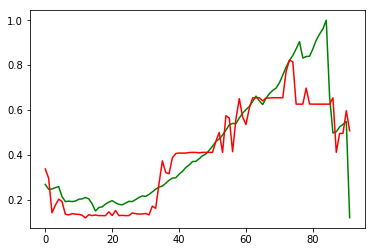

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-05-13:07:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-4496000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-05-13:07:45
INFO:tensorflow:Saving dict for global step 4496000: global_step = 4496000, loss = 0.013597948
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4496000: ./outputdir/model.ckpt-4496000
error on testset first run {'loss': 0.013597948, 'global_step': 4496000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-4496000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO

INFO:tensorflow:global_step/sec: 378.676
INFO:tensorflow:loss = 0.00052319805, step = 4500601 (0.265 sec)
INFO:tensorflow:global_step/sec: 358.068
INFO:tensorflow:loss = 0.0031767418, step = 4500701 (0.279 sec)
INFO:tensorflow:global_step/sec: 299.571
INFO:tensorflow:loss = 0.001165407, step = 4500801 (0.334 sec)
INFO:tensorflow:global_step/sec: 381.934
INFO:tensorflow:loss = 0.003932736, step = 4500901 (0.261 sec)
INFO:tensorflow:global_step/sec: 370.228
INFO:tensorflow:loss = 0.00014436162, step = 4501001 (0.270 sec)
INFO:tensorflow:global_step/sec: 379.141
INFO:tensorflow:loss = 0.0014759301, step = 4501101 (0.264 sec)
INFO:tensorflow:global_step/sec: 373.754
INFO:tensorflow:loss = 0.0034477848, step = 4501201 (0.268 sec)
INFO:tensorflow:global_step/sec: 375.905
INFO:tensorflow:loss = 0.00071416126, step = 4501301 (0.266 sec)
INFO:tensorflow:global_step/sec: 397.529
INFO:tensorflow:loss = 0.0012796364, step = 4501401 (0.252 sec)
INFO:tensorflow:global_step/sec: 377.594
INFO:tensorfl

KeyboardInterrupt: 

In [5]:
## loop over all unique vustomers in dataset
num=1
pred_df = pd.DataFrame()
for client in (df['client_debtor_number'].unique()):
    print("model for customer ",client,"number ",num)
    df_cust = df[df['client_debtor_number'] == client]
    df_cust.drop(['client_debtor_number'],1, inplace=True)
    df_cust['dates'] = df_cust.index.values
    df_cust['dates'] = pd.to_datetime(df_cust['dates'],format= '%d/%m/%Y')
    #weekly data
    week_data = df_cust.set_index('dates').resample('1W').mean()
    df1 = scale_data(week_data.copy())
    df1 = np.array(df1.fv_cost.values)
    SEQLEN = 1  # unrolled sequence length
    BATCHSIZE = 8 #Batchsize
    train_split = 0.8 #80% of data is used as training dataset

    X = df1
    # y is shifted x values in timeseries
    Y = np.roll(df1, -1)
    num_data= X.shape[0]
    #splitting data into train and test
    num_train  = int(train_split * num_data)
    X_train = X[0:num_train]
    Y_train = Y[0:num_train] 
    Y_test = Y[num_train:]
    X_test = X[num_train:]

    #reshaping traun and test sets into model input format
    X_train = np.reshape(X_train, [-1, SEQLEN])
    Y_train = np.reshape(Y_train, [-1, SEQLEN])
 
    X_test = np.reshape(X_test, [-1, SEQLEN])
    Y_test = np.reshape(Y_test, [-1, SEQLEN])
    
    # model parameters
    RNN_CELLSIZE = 80 #number of neurons
    N_LAYERS = 2
    # percentage of random neurons to keep in a layer
    DROPOUT_PKEEP = 0.7
    #directory to store checkpoints
    training_config = tf.estimator.RunConfig(model_dir="./outputdir")
    estimator = tf.estimator.Estimator(model_fn=model_rnn, config=training_config)
    #training on train datset
    estimator.train(input_fn=train_dataset,steps=2000)
    #Predicitons on test data
    results = estimator.predict(eval_dataset)
    Yout_ = [result["Yout"] for result in results]
    #graph to compare test data abd predicitons
    actual = Y_test[:, -1]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.plot(actual, label="Actual Values", color='green')
    plt.plot(Yout_, label="Predicted Values", color='red', )
    plt.show()
    #test dataset MSE error
    eval1 = estimator.evaluate(eval_dataset)
    print ("error on testset first run",eval1)
    
    # last 9 months data for training set of future predicitons
    trainset_x = X[-36:-12]
    trainset_y = Y[-36:-12]
    # last 3 months data for testing set of future predictions
    testset_x = X[-12:]
    testset_y = Y[-12:]

    #prepare the dataset and do predicitons on train and testsets
    X_train = np.reshape(trainset_x, [-1, SEQLEN])
    Y_train = np.reshape(trainset_y, [-1, SEQLEN])
 
    X_test = np.reshape(testset_x, [-1, SEQLEN])
    Y_test = np.reshape(testset_y, [-1, SEQLEN])

    pred_train = estimator.predict(pred_dataset)
    Yout_pred_train = [result["Yout"] for result in pred_train]
    test_pred = estimator.predict(eval_dataset)
    Yout_test_pred = [result["Yout"] for result in test_pred]
    n=22 #since length of Yout_pred_train is 24, 22 is max number of n
    Xtrain = Yout_pred_train 
    Ytrain = np.roll(Yout_pred_train, -1)
    Xtest = Yout_pred_train[-1]
    Ytest = Yout_test_pred[1]
    error_list = []
    predictions = []
    #loop over test data predictions model to get future predictions
    for i in range(1,n): #n or (max-1) of length of Xtrain
        #prepare the dataset in model input format
        X_train = np.reshape(Xtrain, [-1, SEQLEN])
        Y_train = np.reshape(Ytrain, [-1, SEQLEN])
        X_test = np.reshape(Xtest, [-1, SEQLEN])
        Y_test = np.reshape(Ytest, [-1, SEQLEN])   
        #model on train data predicitons
        estimator.train(input_fn=train_dataset,steps=2000)
        #new predicitons on test data
        results = estimator.predict(eval_dataset)
        Yout_ = [result["Yout"] for result in results]
        #Mean squared error
        error_list.append(mean_squared_error(Y_test,Yout_))
        predictions.append(Yout_)
        print("Error at iteration ",i,mean_squared_error(Y_test,Yout_))
        #update train and test datasets
        Xtrain=np.vstack([Yout_pred_train[i:]])
        Ytrain = np.vstack([Yout_pred_train[i+1:],Xtest])
        Xtest = Ytest
        Ytest = Yout_
        print ("prediction at ",i,Yout_)
        pred_df = pred_df.append({'client_number': client, 'pred_step': i, 'prediction':Yout_}, ignore_index=True)
    pred_df.to_csv('predictions/weekly_predictions_tensorflow_'+str(client)+'.csv')
    num = num+1


In [ ]:
# convert notebook to .py script
!jupyter nbconvert --to script Tensorflow-Weekly-Data-LSTM-AllCustomers.ipynb